In [3]:
import sys

import pandas as pd
from scipy.spatial.distance import pdist, squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from scipy import stats
alt.data_transformers.enable("vegafusion")
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import requests ## python -m pip install requests 
import json
from pathlib import Path
import io

In [4]:

import numpy as np
import pandas as pd
import altair as alt
import requests
import io
from requests.exceptions import ConnectionError, RequestException
import time

from goatools.obo_parser import GODag
from goatools.rpt.rpt_lev_depth import RptLevDepth
from goatools.anno.gaf_reader import GafReader
from goatools.gosubdag.gosubdag import GoSubDag
from goatools.gosubdag.plot.gosubdag_plot import GoSubDagPlot
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.mapslim import mapslim
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from goatools.godag.go_tasks import get_go2parents

def load_GO_data(obo_file, gaf_file):

    godag = GODag(str(obo_file), optional_attrs=["defn", "relationship"])
    objanno = GafReader(gaf_file, godag=godag)
    ns2assoc = objanno.get_ns2assc()

    return godag, ns2assoc

def GOEA(query_genes, bg_genes, godag, ns2assoc):
    goeaobj = GOEnrichmentStudyNS(
        bg_genes,  # List of mouse protein-coding genes
        ns2assoc,  # geneid/GO associations
        godag,  # Ontologies
        propagate_counts=False,
        alpha=0.05,  # default significance cut-off
        methods=["fdr_bh"],
    )  # defult multipletest correction method
    
    goea_results = goeaobj.run_study(query_genes, prt=None)
    goea_results_all = [
        r for r in goea_results if r.enrichment == "e"
    ]
    goea_results_sig = [
        r for r in goea_results if (r.p_fdr_bh < 0.05) and (r.enrichment == "e")
    ]

    return goea_results_sig


def format_GOEA_results(goea_results_sig, gene_id_to_name=None):
    enriched_variables = [
        'GO',
        'NS',
        'enrichment',
        'name',
        'p_fdr_bh',
        'p_uncorrected',
        'study_count',
        'pop_count',
        'study_n',
        'pop_n',
        'ratio_in_study',
        'ratio_in_pop',
        'study_items',
        'pop_items',
    ]
    enrichment_results = pd.DataFrame()
    for idx, enrichment in enumerate(goea_results_sig):
        for enriched_var in enriched_variables:
            var_value = enrichment.__getattribute__(enriched_var)
            if isinstance(var_value, set):
                if gene_id_to_name is not None:
                    var_value = [gene_id_to_name[gene_id] for gene_id in var_value]
                    var_value = ", ".join(var_value)
                else:
                    var_value = ", ".join(var_value)
            elif isinstance(var_value, tuple):
                var_value = "/".join([str(v) for v in var_value])
            enrichment_results.loc[idx, enriched_var] = var_value
        coverage_frac = enrichment_results.loc[idx, "study_count"] / enrichment_results.loc[idx, "pop_count"]
        enrichment_results.loc[idx, "coverage_frac"] = round(coverage_frac, 3)
        missing_items = enrichment.__getattribute__("pop_items") - enrichment.__getattribute__("study_items")
        missing_items = [gene_id_to_name[gene_id] for gene_id in missing_items]
        enrichment_results.loc[idx, "missing_items"] = ", ".join(missing_items)
    reorder_columns = enriched_variables[:-2] + ["coverage_frac"] + ["study_items", "missing_items", "pop_items"]
    return enrichment_results, reorder_columns

def parse_string_enrichment(query_genes, bg_genes, max_retries=3, retry_delay=5):

    output_format = "tsv"
    # Try to get the current STRING version
    for attempt in range(max_retries):
        try:
            string_version = requests.post(f"https://string-db.org/api/{output_format}/version").text
            string_api_url = "https" + str(string_version.split("https")[1].strip()) + "/api"
            break
        except (ConnectionError, RequestException) as e:
            if attempt == max_retries - 1:
                return pd.DataFrame()  # Return an empty DataFrame
            time.sleep(retry_delay)

    method = "get_string_ids"
    params = {
        "identifiers" : "\r".join(bg_genes),
        "species" : 4896,
        "limit" : 1,
        "echo_query" : 1,
        "caller_identity" : "DIT_HAP_visualization"
    }
    
    # Try to get STRING IDs
    for attempt in range(max_retries):
        try:
            request_url = "/".join([string_api_url, output_format, method])
            results = requests.post(request_url, data=params)
            results.raise_for_status()  # Raise an exception for bad status codes
            break
        except (ConnectionError, RequestException) as e:
            if attempt == max_retries - 1:
                return pd.DataFrame()  # Return an empty DataFrame
            time.sleep(retry_delay)

    bg_string_ids = []
    for line in results.text.strip().split("\n")[1:]:
        l = line.split("\t")
        string_identifier = l[2]
        bg_string_ids.append(string_identifier)

    method = "enrichment"
    params = {
        "identifiers" : "%0d".join(query_genes),
        "background_string_identifiers" : "%0d".join(bg_string_ids),
        "species" : 4896,
        "caller_identity" : "DIT_HAP_visualization",
    }
    
    # Try to get enrichment results
    for attempt in range(max_retries):
        try:
            request_url = "/".join([string_api_url, output_format, method])
            response = requests.post(request_url, data=params)
            response.raise_for_status()  # Raise an exception for bad status codes
            break
        except (ConnectionError, RequestException) as e:
            if attempt == max_retries - 1:
                return pd.DataFrame()  # Return an empty DataFrame
            time.sleep(retry_delay)

    data = response.text
    dataframe = pd.read_csv(io.StringIO(data), sep="\t")
    return dataframe


In [5]:
godag = GODag(str("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo"), optional_attrs=["defn", "relationship"])

/data/c/yangyusheng_optimized/DIT_HAP_pipeline/resources/pombase_data/2025-06-01/ontologies_and_associations/go-basic.obo: fmt(1.2) rel(2025-05-31) 43,448 Terms; optional_attrs(def relationship)


# 1.Load gene curve data

In [3]:
timepoints = ["YES0", "YES1", "YES2", "YES3", "YES4"]

Hayles_essentiality = pd.read_excel("../references/Hayles_2013_OB_merged_categories.xlsx", index_col=0)

GWMs = pd.read_csv("../data/0_raw/GWMs_bootstrap_brown.csv", index_col=0)
GWMs = GWMs.merge(Hayles_essentiality[["Deletion mutant phenotype description", "Category"]], left_index=True, right_index=True, how="left")
for timepoint in timepoints:
    GWMs[f"transformed_{timepoint}_pvalue"] = GWMs[timepoint+"_pvalue"].apply(lambda x: -np.log10(x) if x > 0 else -np.log10(1e-30))

GWMs.rename_axis("Systematic ID", inplace=True)

mitochondrial_genes = pd.read_csv("../references/manual_download_genelist/Gene List Mitochondrion.tsv", sep="\t")["Systematic ID"].tolist()
ribosomal_genes = pd.read_csv("../references/manual_download_genelist/Ribosome Gene List.tsv", sep="\t")["Systematic ID"].tolist()
tranlational_genes = pd.read_csv("../references/manual_download_genelist/Gene List Translation.tsv", sep="\t")["Systematic ID"].tolist()
mitotranslational_genes = pd.read_csv("../references/manual_download_genelist/Mitotranslation Gene List.tsv", sep="\t")["Systematic ID"].tolist()

GWMs["mitochondrial"] = GWMs.index.isin(mitochondrial_genes)
GWMs["ribosomal"] = GWMs.index.isin(ribosomal_genes)
GWMs["translational"] = GWMs.index.isin(tranlational_genes)
GWMs["mitotranslational"] = GWMs.index.isin(mitotranslational_genes)

## Transform the GWMs to avoid the plateau effect

In [4]:
plateau_threshold = 6
plateau_GWMs = GWMs.copy()
plateau_GWMs.loc[:, ["YES0", "YES1", "YES2", "YES3", "YES4"]] = plateau_GWMs.loc[:, ["YES0", "YES1", "YES2", "YES3", "YES4"]].applymap(lambda x: 6 if x > 6 else x)

# 2.Calculte the distance matrix

In [10]:
distance = pdist(plateau_GWMs[["YES0", "YES1", "YES2", "YES3", "YES4"]].values, metric="euclidean")
linkage_matrix = linkage(distance, method="average", optimal_ordering=True)

In [6]:
# # If you have a distance matrix
# distance_matrix = pd.read_csv("../results/bootstrapped_euclidean_distance_matrix_1000.csv", index_col=0)

# # Convert the condensed distance matrix format
# # Only take the upper triangular part of the matrix (excluding diagonal)
# condensed_dist = distance_matrix.values[np.triu_indices(len(distance_matrix), k=1)]

# # Now use the condensed format with linkage
# linkage_matrix = linkage(condensed_dist, method="average")

# 3.Clustering

## Visualization

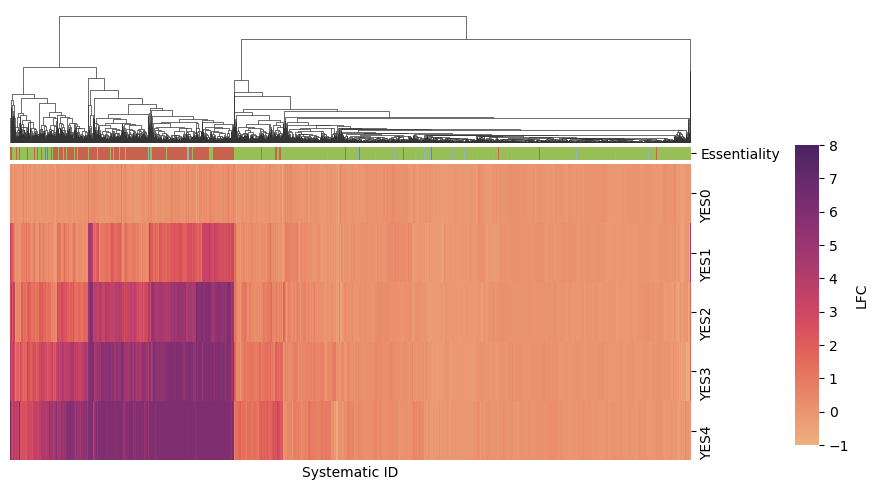

In [7]:
HC_seaborn(plateau_GWMs, "", col_lists=["YES0", "YES1", "YES2", "YES3", "YES4"], linkage_matrix=linkage_matrix)

In [8]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=20, metric="euclidean", linkage="average", compute_distances=True)
model = model.fit(plateau_GWMs[["YES0", "YES1", "YES2", "YES3", "YES4"]].values)
plateau_GWMs["sklearn_cluster"] = model.labels_

<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


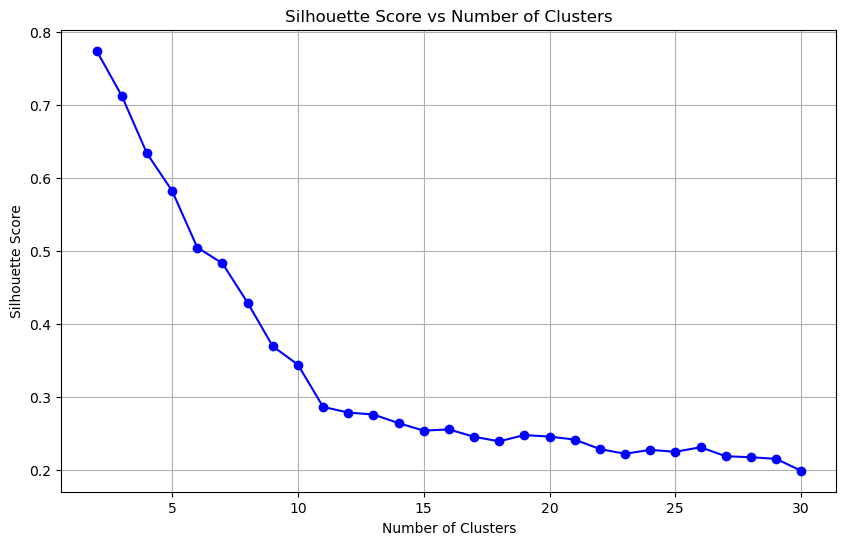

<IPython.core.display.Javascript object>

/data/a/yangyusheng/miniforge3/envs/data_analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Try different numbers of clusters
n_clusters_range = range(2, 31)
silhouette_scores = []

# Calculate silhouette score for each number of clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(plateau_GWMs[["YES0", "YES1", "YES2", "YES3", "YES4"]].values)
    silhouette_avg = silhouette_score(plateau_GWMs[["YES0", "YES1", "YES2", "YES3", "YES4"]].values, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Get optimal number of clusters
optimal_clusters = n_clusters_range[np.argmax(silhouette_scores)]

# # Perform k-means with optimal number of clusters
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans_labels = kmeans.fit_predict(plateau_GWMs[["YES0", "YES1", "YES2", "YES3", "YES4"]].values)

# # Add kmeans cluster labels to dataframe
plateau_GWMs["kmeans_cluster"] = kmeans_labels


## HC clustering

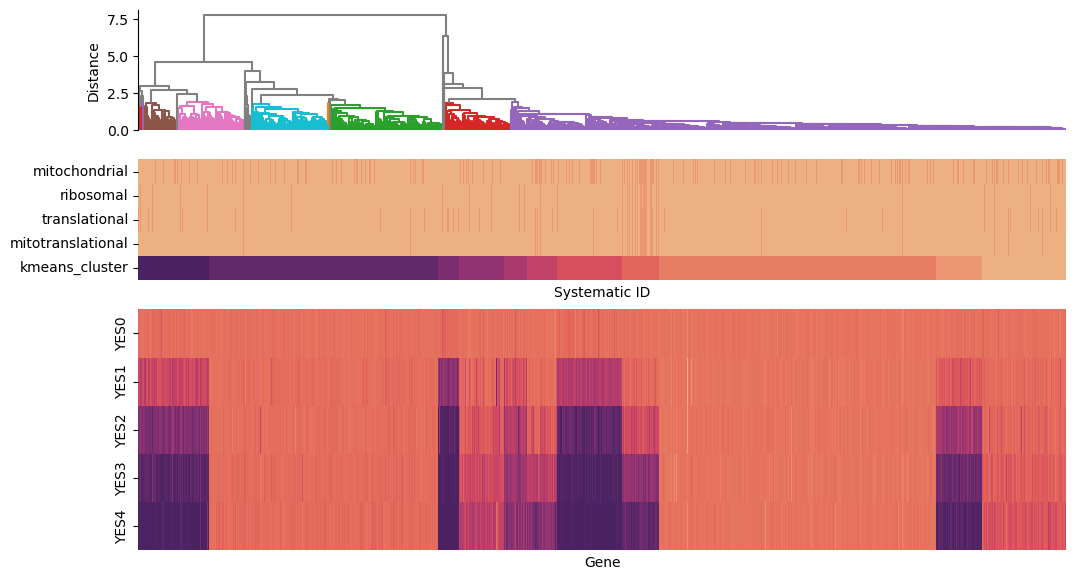

In [24]:
t_threshold = 2
col_lists = ["YES0", "YES1", "YES2", "YES3", "YES4"]
criterion = "distance"

fig, ax = plt.subplots(3, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [1, 1, 2]})
fig.tight_layout(h_pad= 0)
method = "average"
metric = "euclidean"
Ms = plateau_GWMs[col_lists].copy()
Z = linkage(Ms, method=method, metric=metric, optimal_ordering=True)
clusters = fcluster(Z, t=t_threshold, criterion=criterion)
plateau_GWMs["cluster"] = clusters
plateau_GWMs["cluster_count"] = plateau_GWMs["cluster"].map(
    plateau_GWMs["cluster"].value_counts()
)
dendro = dendrogram(Z, color_threshold=t_threshold, above_threshold_color="grey", no_labels=True, count_sort="ascending", ax=ax[0])
leaves = dendro["leaves"]
rotate_clusters = fcluster(Z, t=7, criterion=criterion)
plateau_GWMs["tmp_cluster"] = rotate_clusters
rotate_clusters =plateau_GWMs.iloc[leaves]["tmp_cluster"].values
cluster_names = np.unique(rotate_clusters)
cluster_categories = {}
for idx, (cluster_name, gene_idx) in enumerate(zip(rotate_clusters, leaves)):
    try:
        cluster_categories[cluster_name].append(gene_idx)
    except:
        cluster_categories[cluster_name] = [gene_idx]

# Get the subset of leaves that are in cluster 1
cluster1_leaves_reversed = cluster_categories[1][::-1]
cluster_categories[1] = cluster1_leaves_reversed
reordered_leaves = cluster_categories[1] + cluster_categories[2]
   
# Update leaves with new order
# GWMs_df = plateau_GWMs.iloc[reordered_leaves]
GWMs_df = plateau_GWMs.sort_values(by="kmeans_cluster", ascending=False)
ax[0].spines[["top", "right", "bottom"]].set_visible(False)
ax[0].set_ylabel("Distance")

ax[1].spines[["top", "right", "bottom"]].set_visible(False)
sns.heatmap(GWMs_df.loc[:, ["mitochondrial", "ribosomal", "translational", "mitotranslational", "kmeans_cluster"]].astype(int).T, cmap="flare", cbar=False, ax=ax[1], xticklabels=False)


sns.heatmap(GWMs_df.loc[:, ["YES0", "YES1", "YES2", "YES3", "YES4"]].T, cmap="flare", cbar=False, ax=ax[2], xticklabels=False)
ax[2].set_xlabel("Gene")
plt.show()
plt.close()

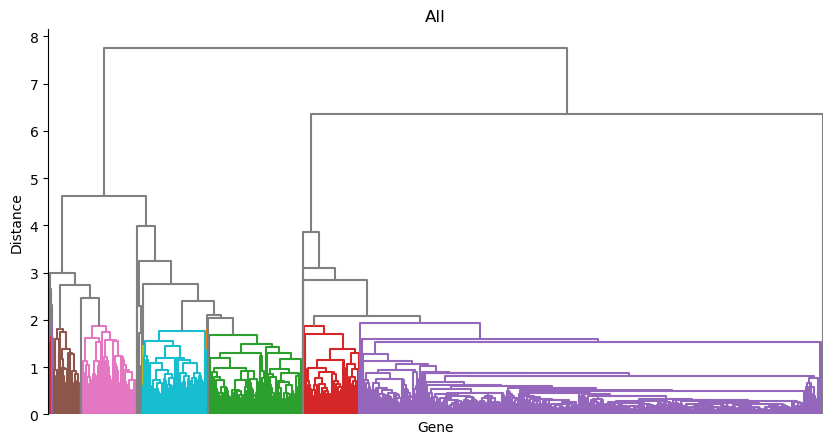

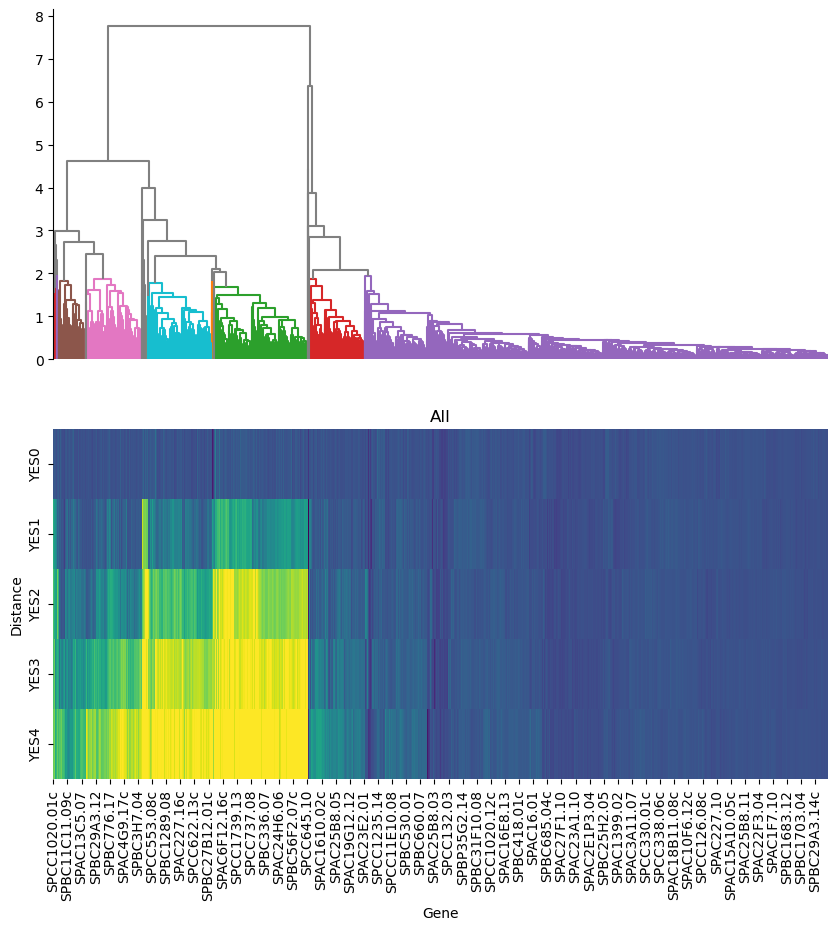

In [24]:
clustered_GWMs_customed_distance = HC_scipy_dendrogram(plateau_GWMs, "All", t_threshold=2, col_lists=["YES0", "YES1", "YES2", "YES3", "YES4"], linkage_matrix=linkage_matrix)
test_df = HC_scipy_dendrogram_modify(plateau_GWMs, "All", criterion="inconsistent", t_threshold=2, col_lists=["YES0", "YES1", "YES2", "YES3", "YES4"], linkage_matrix=linkage_matrix)


ValueError: ['C7', 'C7', 'C7', 'C7', 'C7', 'C15', 'C15', 'C15', 'C6', 'C6', 'C6', 'C6', 'C6', 'C6', 'C6', 'C6', 'C6', 'C6', 'C6', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C13', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C10', 'C16', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C5', 'C11', 'C11', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C8', 'C8', 'C8', 'C8', 'C8', 'C8', 'C8', 'C8', 'C8', 'C8', 'C8', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C12', 'C17', 'C9', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C-1', 'C18', 'C14'] is not a valid value for color

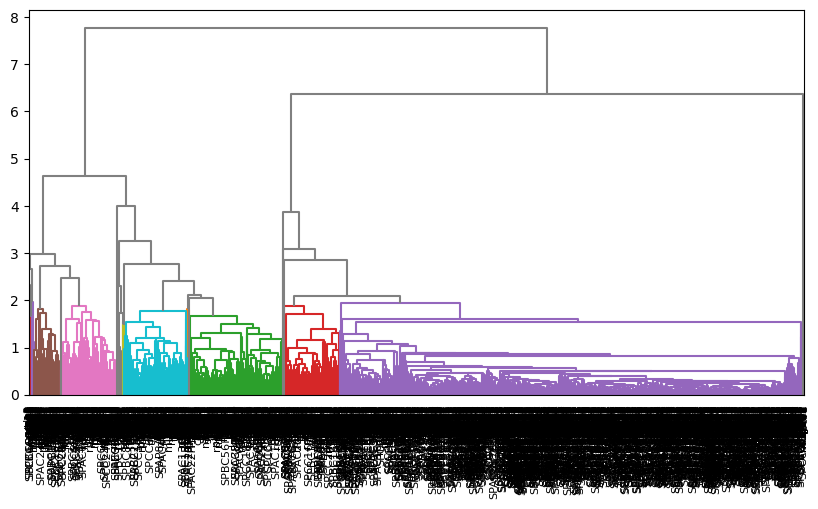

In [12]:
# Plot dendrogram with sklearn labels
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Plot dendrogram
dendro = dendrogram(linkage_matrix, color_threshold=t_threshold, 
                   above_threshold_color='grey', 
                   leaf_rotation=90,
                   leaf_font_size=8)

# Color labels based on clusters
ax.set_xticklabels(plateau_GWMs.iloc[dendro['leaves']]['Name'], 
                   rotation=90, ha='center',
                   color=[f'C{c-1}' for c in plateau_GWMs.iloc[dendro['leaves']]['sklearn_cluster']])

ax.spines[['top', 'right', 'bottom']].set_visible(False)
ax.set_ylabel('Distance')
plt.tight_layout()
plt.show()
plt.close()


# 4.Curve plot

In [11]:
def cluster_curve_plot(GWMs_df):
    if "revised_cluster" in GWMs_df.columns:
        cluster = "revised_cluster"
    else:
        cluster = "cluster"
    GM_line = GWMs_df.copy()
    GM_line = (
        GM_line.set_index([cluster, "cluster_count"], append=True)[
            ["YES0", "YES1", "YES2", "YES3", "YES4"]]
        .stack()
        .rename_axis(["gene_name", cluster, "cluster_count", "timepoint"])
        .rename("M")
        .reset_index()
    )
    original_Gs = pd.Series(
        [0.533, 2.808, 6.197, 9.493, 13.02], index=["YES0", "YES1", "YES2", "YES3", "YES4"]
    )
    GM_line["G"] = GM_line["timepoint"].map(original_Gs)

    GM_lines = GM_line

    base = alt.Chart(GM_lines.query(
        "cluster_count > 40"))

    line = (
        base
        .mark_line()
        .encode(x="G",
                y=alt.Y("median(M)", scale=alt.Scale(domain=[-1, 10])),
                color=f"{cluster}:N")
    )

    band = (
        base
        .mark_errorband(extent="iqr")
        .encode(x="G", y=alt.Y("M"), color=f"{cluster}:N")
    )

    return line+band

In [12]:
cluster_curve_plot(clustered_GWMs_customed_distance)

alt.LayerChart(...)

# 5.Rename cluster

In [61]:
# renamed_cluster_map = {
#     2: "level_0",
#     3: "level_1",
#     9: "level_2",
#     12: "level_3",
#     11: "level_4",
#     7: "level_5",
#     6: "level_6",
#     21: "level_7",
#     20: "level_8",
#     23: "level_9",
#     24: "level_10",
#     19: "level_11",
# }

renamed_cluster_map = {
    1: "level_0",
    4: "level_1",
    5: "level_2",
    3: "level_3",
    9: "level_4",
    10: "level_5",
    8: "level_6",
}

clustered_GWMs_customed_distance["revised_cluster"] = clustered_GWMs_customed_distance["cluster"].map(renamed_cluster_map)
clustered_GWMs_customed_distance["revised_cluster"] = clustered_GWMs_customed_distance["revised_cluster"].fillna("Miscellaneous")
cluster_curve_plot(clustered_GWMs_customed_distance)

alt.LayerChart(...)

# 6. Enrichment analysis

In [65]:
bg_genes = clustered_GWMs_customed_distance.index.tolist()
obo_file = Path(
                "../references/20241001/go-basic.obo")
gaf_file = Path(
    "../references/20241001/go_style_gaf.tsv")
godag, ns2assoc = load_GO_data(obo_file, gaf_file)

concated_GOEA_results = {}
for cluster, cluster_df in clustered_GWMs_customed_distance.groupby("revised_cluster"):
    query_genes = cluster_df.index.tolist()
    go_sig = GOEA(query_genes, bg_genes, godag, ns2assoc)
    go_sig_results, reorder_columns = format_GOEA_results(go_sig, gene_id_to_name)
    concated_GOEA_results[cluster] = go_sig_results


../references/20241001/go-basic.obo: fmt(1.2) rel(2024-09-27) 44,053 Terms; optional_attrs(def relationship)
HMS:0:00:00.848500  45,290 annotations READ: ../references/20241001/go_style_gaf.tsv 

Load BP Ontology Enrichment Analysis ...
 88%  3,865 of  4,393 population items found in association

Load CC Ontology Enrichment Analysis ...
 97%  4,253 of  4,393 population items found in association

Load MF Ontology Enrichment Analysis ...
 81%  3,563 of  4,393 population items found in association

Load BP Ontology Enrichment Analysis ...
 88%  3,865 of  4,393 population items found in association

Load CC Ontology Enrichment Analysis ...
 97%  4,253 of  4,393 population items found in association

Load MF Ontology Enrichment Analysis ...
 81%  3,563 of  4,393 population items found in association

Load BP Ontology Enrichment Analysis ...
 88%  3,865 of  4,393 population items found in association

Load CC Ontology Enrichment Analysis ...
 97%  4,253 of  4,393 population items found in a

In [66]:
FYPO_file = Path(
        "../references/20241001/fypo-simple.obo")
FYPO_gaf_file = Path(
    "../references/20241001/phaf_go_style_gaf.tsv")
FYPOdag, ns2FYPOassoc = load_GO_data(FYPO_file, FYPO_gaf_file)

concated_FYPOEA_results = {}
for cluster, cluster_df in clustered_GWMs_customed_distance.groupby("revised_cluster"):
    query_genes = cluster_df.index.tolist()
    fy_sig = GOEA(query_genes, bg_genes, FYPOdag, ns2FYPOassoc)
    fy_sig_results, reorder_columns = format_GOEA_results(fy_sig, gene_id_to_name)
    concated_FYPOEA_results[cluster] = fy_sig_results

../references/20241001/fypo-simple.obo: fmt(1.2) rel(2020-05-12) 7,187 Terms; optional_attrs(def relationship)
HMS:0:00:02.173649 111,637 annotations READ: ../references/20241001/phaf_go_style_gaf.tsv 

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 population items found in association

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 population items found in association

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 population items found in association

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 population items found in association

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 population items found in association

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 population items found in association

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 population items found in association

Load FYPO Ontology Enrichment Analysis ...
 99%  4,328 of  4,393 popu

In [67]:
string_enrichment = {}

for cluster, cluster_df in clustered_GWMs_customed_distance.groupby("revised_cluster"):
    query_genes = cluster_df.index.tolist()
    string_sig = parse_string_enrichment(query_genes, bg_genes)
    string_enrichment[cluster] = string_sig

In [68]:
concated_GOEA_results = pd.concat(concated_GOEA_results, axis=0)
concated_FYPOEA_results = pd.concat(concated_FYPOEA_results, axis=0)
string_enrichment = pd.concat(string_enrichment, axis=0)


In [69]:
concated_GOEA_results = concated_GOEA_results.droplevel(level=-1, axis=0).rename_axis("Cluster").reset_index()
concated_FYPOEA_results = concated_FYPOEA_results.droplevel(level=-1, axis=0).rename_axis("Cluster").reset_index()
string_enrichment = string_enrichment.droplevel(level=-1, axis=0).rename_axis("Cluster").reset_index()


In [73]:
filtered_concated_GOEA_results = concated_GOEA_results.query("Cluster != 'Miscellaneous' and p_fdr_bh < 0.01")
filtered_concated_FYPOEA_results = concated_FYPOEA_results.query("Cluster != 'Miscellaneous' and p_fdr_bh < 0.01")
filtered_string_enrichment = string_enrichment.query("Cluster != 'Miscellaneous' and category == 'NetworkNeighborAL' and fdr < 0.01")


In [74]:
concated_GOEA_results_plot = []
for NS, NS_df in filtered_concated_GOEA_results.groupby("NS"):
    chart = alt.Chart(NS_df).mark_circle().encode(
        x=alt.X("Cluster:N", axis=alt.Axis(grid=True), sort=["level_0", "level_1", "level_2", "level_3", "level_4", "level_5", "level_6"]),
        y=alt.Y(
                    "name:N",
                    axis=alt.Axis(grid=True, labelLimit=500, title=""),
                    sort=alt.EncodingSortField(
                        field="Cluster", order="ascending"),
                ),
        color=alt.Color("p_fdr_bh:Q").scale(
                    scheme="yelloworangered", reverse=True),
        tooltip=NS_df.columns.tolist(),
        size="coverage_frac")
    concated_GOEA_results_plot.append(chart)
alt.hconcat(*concated_GOEA_results_plot)#.save("../results/GOEA_results_plot.html")

alt.HConcatChart(...)

In [87]:
concated_FYPOEA_results_plot = []
for NS, NS_df in filtered_concated_FYPOEA_results.groupby("NS"):
    chart = alt.Chart(NS_df).mark_circle().encode(
        x=alt.X("Cluster:N", axis=alt.Axis(grid=True), sort=["level_0", "level_1", "level_2", "level_3", "level_4", "level_5", "level_6"]),
        y=alt.Y(
                    "name:N",
                    axis=alt.Axis(grid=True, labelLimit=500, title=""),
                    sort=alt.EncodingSortField(
                        field="Cluster", order="ascending"),
                ),
        color=alt.Color("p_fdr_bh:Q").scale(
                    scheme="yelloworangered", reverse=True),
        tooltip=NS_df.columns.tolist(),
        size="coverage_frac")
    concated_FYPOEA_results_plot.append(chart)
alt.hconcat(*concated_FYPOEA_results_plot)#.save("../results/FYPOEA_results_plot.html")

alt.HConcatChart(...)

In [85]:
category_description = {
            "Process": "Biological Process (Gene Ontology)",
            "Component": "Cellular Component (Gene Ontology)",
            "Function": "Molecular Function (Gene Ontology)",
            "PMID": "Reference Publications (PubMed)",
            "NetworkNeighborAL": "Local Network Cluster (STRING)",
            "KEGG": "KEGG Pathways",
            "RCTM": "Reactome Pathways",
            "COMPARTMENTS": "Subcellular Localization (COMPARTMENTS)",
            "Keyword": "Annotated Keywords (UniProt)",
            "InterPro": "Protein Domains and Features (InterPro)",
            "SMART": "Protein Domains and Features (SMART)",
        }
category_order = list(category_description.keys())
string_enrichment['category_order'] = string_enrichment['category'].map({v: i for i, v in enumerate(category_order)})
string_enrichment.sort_values(by='category_order', inplace=True)
string_enrichment.drop('category_order', axis=1, inplace=True)
string_enrichment["category"] = string_enrichment["category"].map(category_description)

In [88]:
concated_string_enrichment_plot = []
for category, category_df in filtered_string_enrichment.groupby("category", sort=False):
    chart = alt.Chart(category_df).mark_circle().encode(
        x=alt.X("Cluster:N", axis=alt.Axis(grid=True), sort=["level_0", "level_1", "level_2", "level_3", "level_4", "level_5", "level_6"]),
        y=alt.Y(
                    "description:N",
                    axis=alt.Axis(grid=True, labelLimit=500, title=""),
                    sort=alt.EncodingSortField(
                        field="Cluster", order="ascending"),
                ),
        color=alt.Color("fdr:Q").scale(
                    scheme="yelloworangered", reverse=True),
        tooltip=category_df.columns.tolist(),
        size=alt.Size("number_of_genes", scale=alt.Scale(type="log")),
        ).properties(
            title=category
        )
    concated_string_enrichment_plot.append(chart)
alt.hconcat(*concated_string_enrichment_plot).resolve_scale(color="independent", size="independent")#.save("../results/string_enrichment_plot.html")


alt.HConcatChart(...)

In [ ]:
AnGeLi_enrichment_folder = Path("../data/cluster_enrichment_AnGeLi/")
AnGeLi_enrichment_dfs = {}
for file in AnGeLi_enrichment_folder.glob("*.tsv"):
    cluster = file.stem.rstrip("_enrichment")
    AnGeLi_enrichment_df = pd.read_csv(file, sep="\t")
    AnGeLi_enrichment_df["Cluster"] = cluster
    AnGeLi_enrichment_dfs[cluster] = AnGeLi_enrichment_df

In [ ]:
concatenated_AnGeLi_enrichment = pd.concat(AnGeLi_enrichment_dfs.values(), axis=0)

# def extract_enrich_values(cell):
#     if "(" in cell:
#         enrich_value = float(cell.split("(")[1].split("/")[0].strip())
#         return enrich_value
#     else:
#         return float(cell)
# concatenated_AnGeLi_enrichment["Enrichment_values"] = concatenated_AnGeLi_enrichment["List_Frequency"].apply(extract_enrich_values)

concated_AnGeLi_enrichment_plot = []
for category, category_df in concatenated_AnGeLi_enrichment.groupby("Category_Name"):
    chart = alt.Chart(category_df).mark_circle().encode(
        x=alt.X("Cluster:N", axis=alt.Axis(grid=True), sort=["level_0", "level_1", "level_2", "level_3", "level_4", "level_5", "level_6"]),
        y=alt.Y("GeneSet_Name:N", axis=alt.Axis(grid=True, labelLimit=500, title=""), sort=alt.EncodingSortField(field="Cluster", order="ascending")),
        color=alt.Color("Corrected_pvalue:Q").scale(scheme="yelloworangered", reverse=True),
        column="over_represented/under_represented:N",
        tooltip=category_df.columns.tolist(),
    ).properties(title=category)
    concated_AnGeLi_enrichment_plot.append(chart)
alt.vconcat(*concated_AnGeLi_enrichment_plot).save("../results/AnGeLi_enrichment_plot.html")

# 7.High coverage enrichment analysis

In [45]:
high_coverage_GOEA_results = concated_GOEA_results.query("coverage_frac > 0.7 and NS != 'MF' and Cluster != 'level_0'").copy()
high_coverage_FYPOEA_results = concated_FYPOEA_results.query("coverage_frac > 0.7 and NS != 'MF' and Cluster != 'level_0'").copy()


In [46]:
string_enrichment["coverage_frac"] = string_enrichment["number_of_genes"] / string_enrichment["number_of_genes_in_background"]
high_coverage_string_enrichment = string_enrichment.query("coverage_frac > 0.7 and Cluster != 'level_0'").copy()

In [47]:
with pd.ExcelWriter("../results/high_coverage_GOEA_and_FYPOEA_and_string_enrichment_results.xlsx") as writer:
    high_coverage_GOEA_results.to_excel(writer, sheet_name="GOEA", index=False)
    high_coverage_FYPOEA_results.to_excel(writer, sheet_name="FYPOEA", index=False)
    high_coverage_string_enrichment.to_excel(writer, sheet_name="string_enrichment", index=False)

In [1]:
high_coverage_GOEA_results = pd.read_excel("../results/high_coverage_GOEA_and_FYPOEA_and_string_enrichment_results.xlsx", sheet_name="GOEA")
high_coverage_FYPOEA_results = pd.read_excel("../results/high_coverage_GOEA_and_FYPOEA_and_string_enrichment_results.xlsx", sheet_name="FYPOEA")
high_coverage_string_enrichment = pd.read_excel("../results/high_coverage_GOEA_and_FYPOEA_and_string_enrichment_results.xlsx", sheet_name="string_enrichment")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [133]:
Euler_plot_dir = Path("../results/Euler_plot/")
Euler_plot_dir.mkdir(parents=True, exist_ok=True)

for (cluster, NS), cluster_df in high_coverage_GOEA_results.groupby(["Cluster", "NS"]):
    # cluster_df["name"] = cluster_df["name"].str.replace("/", " or ")
    # cluster_df["name"] = cluster_df["name"].str.replace(",", "  ")
    # cluster_df["name"] = cluster_df["name"].str.replace(";", "  ")
    # cluster_df["name"] = cluster_df["name"].str.replace("(", " ")
    # cluster_df["name"] = cluster_df["name"].str.replace(")", " ")
    # cluster_df["name"] = cluster_df["name"].str.replace("-", "_")
    recteuler_df = cluster_df.set_index(["Cluster", "name"])["pop_items"].str.split(", ").explode().reset_index()
    recteuler_df["value"] = 1
    recteuler_df.pivot(index="pop_items", columns="name", values="value").fillna(0).astype(int).to_csv(Euler_plot_dir / f"{cluster}_{NS}.csv")


In [125]:
high_coverage_GOEA_results

,Cluster,GO,NS,enrichment,name,p_fdr_bh,p_uncorrected,study_count,pop_count,study_n,pop_n,ratio_in_study,ratio_in_pop,study_items,pop_items,coverage_frac,missing_items
19,level_2,GO:0000221,CC,e,"vacuolar proton-transporting V-type ATPase, V1...",1.200028e-05,1.604315e-08,6.0,6.0,223.0,4393.0,6/223,6/4393,"vma8, vma13, vma4, vma1, vma2, vma5","vma8, vma13, vma4, vma1, vma2, vma5",1.000,
21,level_2,GO:0070847,CC,e,core mediator complex,1.553793e-03,6.231789e-06,5.0,7.0,223.0,4393.0,5/223,7/4393,"pmc4, med14, med8, srb4, med7","pmc4, med14, med8, srb4, med6, med31, med7",0.714,"med31, med6"
27,level_2,GO:0030870,CC,e,Mre11 complex,9.659724e-03,1.291407e-04,3.0,3.0,223.0,4393.0,3/223,3/4393,"mre11, rad50, nbs1","mre11, rad50, nbs1",1.000,
28,level_2,GO:0030956,CC,e,glutamyl-tRNA(Gln) amidotransferase complex,9.659724e-03,1.291407e-04,3.0,3.0,223.0,4393.0,3/223,3/4393,"gta2, gta1, gta3","gta2, gta1, gta3",1.000,
29,level_2,GO:0098654,CC,e,CENP-A recruiting complex,3.380603e-02,4.971476e-04,3.0,4.0,223.0,4393.0,3/223,4/4393,"mis18, mis16, mis19","mis16, mis20, mis19, mis18",0.750,mis20
35,level_3,GO:0005762,CC,e,mitochondrial large ribosomal subunit,1.547011e-21,2.068197e-24,26.0,37.0,262.0,4393.0,26/262,37/4393,"mrp11, mrpl10, mrpl25, mrpl7, mrpl8, mrpl23, m...","mrp11, mrpl39, mrpl1, img2, mrpl32, mrpl10, mr...",0.703,"mrpl39, SPCC777.17c, new15, mrpl1, pth4, img2,..."
37,level_3,GO:0031511,CC,e,Mis6-Sim4 complex,1.256610e-09,5.039880e-12,10.0,11.0,262.0,4393.0,10/262,11/4393,"cnl2, mal2, mis15, mis17, fta4, fta1, fta7, si...","cnl2, mal2, mis15, fta1, mis17, fta4, fta7, si...",0.909,fta6
38,level_3,GO:0000220,CC,e,"vacuolar proton-transporting V-type ATPase, V0...",1.361003e-04,7.278092e-07,5.0,5.0,262.0,4393.0,5/262,5/4393,"vma6, vma9, vma11, vma3, vph1","vma6, vma9, vma11, vma3, vph1",1.000,
40,level_3,GO:0033588,CC,e,elongator holoenzyme complex,5.516019e-03,5.899486e-05,4.0,5.0,262.0,4393.0,4/262,5/4393,"elp3, elp6, elp2, elp5","elp3, elp1, elp2, elp6, elp5",0.800,elp1
41,level_3,GO:0031391,CC,e,Elg1 RFC-like complex,5.516019e-03,5.899486e-05,4.0,5.0,262.0,4393.0,4/262,5/4393,"rfc3, rfc5, rfc2, rfc4","rfc4, elg1, rfc5, rfc3, rfc2",0.800,elg1


# 8.Compare with other features

In [98]:
other_features = pd.read_excel("../references/0_all_features.xlsx", index_col=0).set_index("Pombe_SysName")
other_features_with_cluster = other_features.merge(clustered_genes, left_index=True, right_index=True, how="inner")

bypassable_genes = pd.read_excel("../references/41467_2019_8928_MOESM4_ESM.xlsx", index_col=0, skiprows=1)
other_features_with_cluster = other_features_with_cluster.merge(bypassable_genes[["Bypassability"]], left_index=True, right_index=True, how="left")
filtered_other_features_with_cluster = other_features_with_cluster.query("revised_cluster != 'Miscellaneous'")

In [138]:
value_columns = ["mRNA_abundance", "protein_abundance_99", "Protein_degradation_rate", "4_gene_evolution_rate", "CAI", "tAIg", "Hermes_Integration_density", "num_Sc_ortholog", "Number_of_species_with_orthologs"]
rename_columns = {
    "mRNA_abundance": "mRNA Abundance",
    "protein_abundance_99": "Protein Abundance",
    "Protein_degradation_rate": "Protein Degradation Rate",
    "4_gene_evolution_rate": "Gene Evolution Rate",
    "CAI": "CAI",
    "tAIg": "tAIg",
    "Hermes_Integration_density": "Hermes Integration Density",
    "num_Sc_ortholog": "Number of Sc Orthologs",
    "Number_of_species_with_orthologs": "Number of Species with Orthologs",
}
value_column_scale = {
    "mRNA_abundance": "log",
    "protein_abundance_99": "log",
    "Protein_degradation_rate": "log",
    "4_gene_evolution_rate": "linear",
    "CAI": "linear",
    "tAIg": "linear",
    "Hermes_Integration_density": "linear",
    "num_Sc_ortholog": "log",
    "Number_of_species_with_orthologs": "linear",
}


In [139]:
value_charts = []
for value_column in value_columns:  
    chart = alt.Chart(filtered_other_features_with_cluster).mark_boxplot(outliers=False).encode(
        x=alt.X("revised_cluster", axis=alt.Axis(grid=True), sort=["level_0", "level_1", "level_2", "level_3", "level_4", "level_5", "level_6"]),
        y=alt.Y(value_column, type="quantitative", scale=alt.Scale(type=value_column_scale[value_column]), title=rename_columns[value_column]),
    ).properties(title=rename_columns[value_column])
    value_charts.append(chart)
alt.hconcat(*value_charts)

alt.HConcatChart(...)

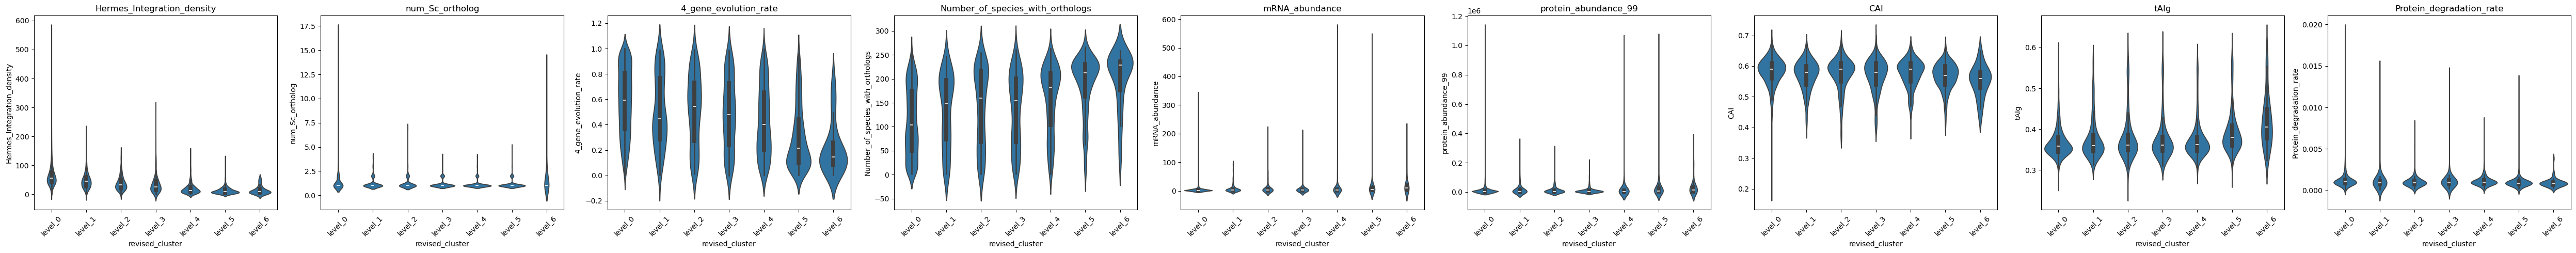

In [108]:
fig, axes = plt.subplots(1, len(value_columns), figsize=(50, 5))
for i, value_column in enumerate(value_columns):
    sns.violinplot(data=filtered_other_features_with_cluster, 
                x="revised_cluster", 
                y=value_column,
                order=["level_0", "level_1", "level_2", "level_3", "level_4", "level_5", "level_6"],
                ax=axes[i])
    axes[i].set_title(value_column)
    # if value_column_scale[value_column] == "log":
    #     axes[i].set_yscale("log")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [101]:
category_variables = {
    "lethality": "rapid lethality",
    "with_nonessential_Sc_ortholog": "yes",
    "without_essential_Sc_orthologs": "no",
    "Bypassability": "non-bypassable",
}

def calculate_category_ratio(df, category_variables):
    ratio_series = pd.Series(dtype="float64")
    for category, category_name in category_variables.items():
        ratio_series[category] = df.query(f"{category} == '{category_name}'").shape[0] / df.shape[0]
    return ratio_series


category_ratios = other_features_with_cluster.groupby("revised_cluster").apply(lambda sub_df: calculate_category_ratio(sub_df, category_variables)).reset_index()
filtered_category_ratios = category_ratios.query("revised_cluster != 'Miscellaneous'")

In [102]:
alt.Chart(filtered_category_ratios).mark_bar().encode(
    x="revised_cluster",
    y=alt.Y(alt.repeat("column"), type="quantitative", scale=alt.Scale(domain=[0, 1])),
).properties(
    width=100
).repeat(
    column=list(category_variables.keys())
)

alt.RepeatChart(...)

In [45]:
clustered_GWMs_customed_distance["Category"] = clustered_GWMs_customed_distance["Category"].fillna("Not analyzed")

categories = ["spores", "germinated", "microcolonies", "very small colonies", "small colonies", "WT"]
filtered_clustered_GWMs_customed_distance = clustered_GWMs_customed_distance.query("Category in @categories")
alt.Chart(filtered_clustered_GWMs_customed_distance).mark_bar().encode(
    x = "revised_cluster",
    y = "count(Category)",
    color = alt.Color("Category", sort=categories),
) | alt.Chart(filtered_clustered_GWMs_customed_distance).mark_bar().encode(
    x = "revised_cluster",
    y = alt.Y("count(Category)", stack="normalize"),
    color = alt.Color("Category", sort=categories),
)

alt.HConcatChart(...)

In [ ]:
clustered_GWMs_customed_distance["Category"] = clustered_GWMs_customed_distance["Category"].fillna("Not analyzed")

categories = ["spores", "germinated", "microcolonies", "very small colonies", "small colonies", "WT"]
filtered_clustered_GWMs_customed_distance = clustered_GWMs_customed_distance.query("Category in @categories")
alt.Chart(filtered_clustered_GWMs_customed_distance).mark_bar().encode(
    x = "revised_cluster",
    y = "count(Category)",
    color = alt.Color("Category", sort=categories),
) | alt.Chart(filtered_clustered_GWMs_customed_distance).mark_bar().encode(
    x = "revised_cluster",
    y = alt.Y("count(Category)", stack="normalize"),
    color = alt.Color("Category", sort=categories),
)